**1. Creación de los datos:**

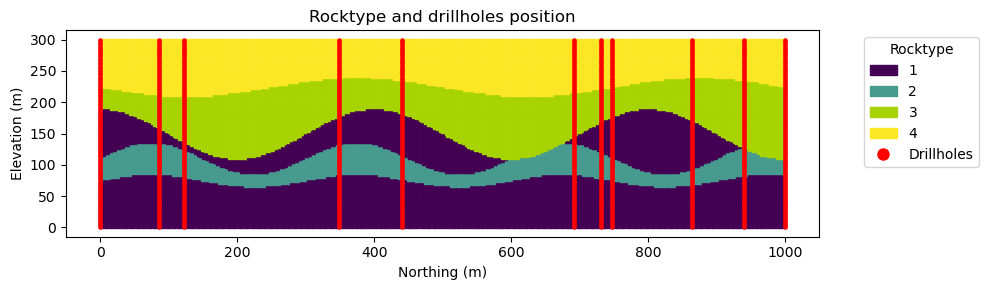

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
cmap_discreta = ListedColormap(['#440154', '#469A8E', '#A7D400', '#FDE725'])

# Parámetros
x_size = 1000
z_size = 300
num_points_x = 400
num_points_z = 120

x_coords = np.linspace(0, x_size, num_points_x)
z_coords = np.linspace(0, z_size, num_points_z)
X, Z = np.meshgrid(x_coords, z_coords)

# Parámetros de ondulación para cada capa (amplitud, longitud de onda, fase)  - valores ajustados para mayor suavidad
layer_params = [
    {'amplitude': 10, 'wavelength': 300, 'phase': 0},  # Capa 1
    {'amplitude': 40, 'wavelength': 400, 'phase': np.pi/2},  # Capa 2
    {'amplitude': 15, 'wavelength': 500, 'phase': np.pi},  # Capa 3
    {'amplitude': 10, 'wavelength': 200, 'phase': 3*np.pi/2}   # Capa 4
]

# Definir las capas con forma ondular independiente y superposición para transiciones suaves
rocktype = np.zeros((num_points_z, num_points_x), dtype=int)
noise = np.random.normal(0, 0, size=(num_points_z, num_points_x)) #Menos ruido

# Generamos las capas con las ondulaciones especificadas. Se añade superposición
layer1 = z_size/4 + layer_params[0]['amplitude'] * np.sin(2 * np.pi * X / layer_params[0]['wavelength'] + layer_params[0]['phase']) + noise
layer2 = z_size/2 + layer_params[1]['amplitude'] * np.sin(2 * np.pi * X / layer_params[1]['wavelength'] + layer_params[1]['phase']) + noise
layer3 = 3*z_size/4 + layer_params[2]['amplitude'] * np.sin(2 * np.pi * X / layer_params[2]['wavelength'] + layer_params[2]['phase']) + noise

# Superposición: Creamos zonas de transición entre capas.
transition_width = 30 #Ancho de la zona de transición.

rocktype[Z < layer1] = 1
rocktype[(Z >= layer1) & (Z < layer2)] = 2
rocktype[(Z >= layer2) & (Z < layer3)] = 3
rocktype[Z >= layer3] = 4

#Suavizamos las transiciones entre capas.
for i in range(1, 4):
    #Identificamos los indices donde se unen las capas.
    indices = np.where((Z >= layer1) & (Z < layer2))
    # Aplicamos superposición
    for j in range(len(indices[0])):
        if i==2:
            if indices[0][j] >= int(layer1[indices[0][j], indices[1][j]] - transition_width) and indices[0][j] <= int(layer1[indices[0][j], indices[1][j]] + transition_width):
                rocktype[indices[0][j], indices[1][j]] = 1
        if i==3:
            if indices[0][j] >= int(layer2[indices[0][j], indices[1][j]] - transition_width) and indices[0][j] <= int(layer2[indices[0][j], indices[1][j]] + transition_width):
                rocktype[indices[0][j], indices[1][j]] = 2
        if i==4:
            if indices[0][j] >= int(layer3[indices[0][j], indices[1][j]] - transition_width) and indices[0][j] <= int(layer3[indices[0][j], indices[1][j]] + transition_width):
                rocktype[indices[0][j], indices[1][j]] = 3

# Crear el DataFrame principal
df_completo = pd.DataFrame({
    'X': np.tile(x_coords, num_points_z),
    'Z': np.repeat(z_coords, num_points_x),
    'Rocktype': rocktype.flatten()
})

# Crear un subconjunto de datos simulando sondajes verticales
num_sondajes = 11  # Número total de sondajes
# Asegurar que hay un sondaje en X = 0 y X = 1000
indices_sondajes = [0, num_points_x - 1]  # 0 y 399 son los índices de X = 0 y X = 1000

# Calcular el número de sondajes restantes
remaining_sondajes = num_sondajes - len(indices_sondajes)

# Generar índices de los sondajes restantes
if remaining_sondajes > 0:
    # Generar un rango entre 1 y num_points_x - 1 pero excluyendo las posiciones 0 y 399
    available_indices = np.arange(1, num_points_x - 1)  # Excluyendo ya 0 y 1000
    # Seleccionar índices aleatorios, asegurando que la separación es adecuada

    seed_value = 186515
    rng = np.random.RandomState(seed_value) # Crea un generador de números aleatorios con semilla
    chosen_indices = rng.choice(available_indices, remaining_sondajes, replace=False)

    indices_sondajes.extend(chosen_indices)

# Crear una lista para almacenar los DataFrames de cada sondaje
sondajes_list = []

# Extraemos todos los valores de Z correspondientes a cada X seleccionado
for indice in indices_sondajes:
    # Creamos un DataFrame con todas las filas de Z para el X actual
    df_sondaje_vertical = df_completo.iloc[indice::num_points_x]
    # Agregamos este DataFrame a la lista
    sondajes_list.append(df_sondaje_vertical)

# Concatenamos todos los DataFrames de los sondajes en uno solo
df_sondajes = pd.concat(sondajes_list, ignore_index=True)

# Crear el gráfico
plt.figure(figsize=(10, 3))
plt.scatter(df_completo['X'], df_completo['Z'], c=df_completo['Rocktype'], cmap=cmap_discreta, s=1, marker="s")  # Rocktype_rbf
plt.scatter(df_sondajes['X'], df_sondajes['Z'], c='red', s=5, marker='o', label='Drillholes')

plt.xlabel('Northing (m)')
plt.ylabel('Elevation (m)')
plt.title('Rocktype and drillholes position')

# Agregar una leyenda fuera del gráfico
patches = [plt.Rectangle((0, 0), 1, 1, color=cmap_discreta(i)) for i in range(4)]
plt.legend(patches + [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Drillholes')],
           [1, 2, 3, 4, 'Drillholes'], title='Rocktype', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.savefig("images_3/rocktype_real.png", dpi=300)
plt.show()

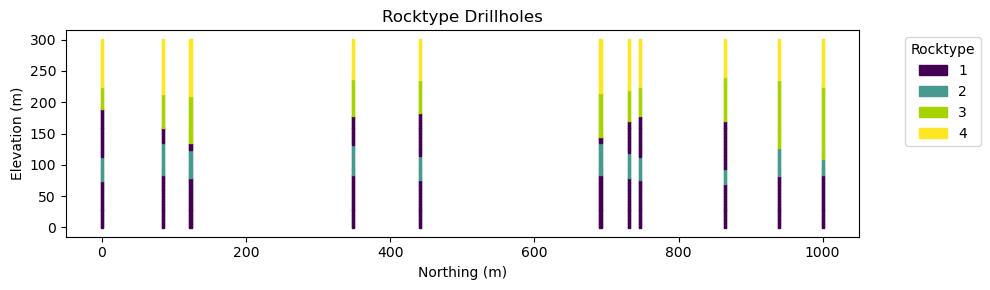

In [23]:
# Crear el gráfico
plt.figure(figsize=(10, 3))
plt.scatter(df_sondajes['X'], df_sondajes['Z'], c=df_sondajes['Rocktype'], cmap=cmap_discreta, s=2.5, marker="s")  # Rocktype_rbf
#plt.scatter(df['X'], df['Z'], c=df['Rocktype'], cmap=cmap_discreta, s=20, marker='o', label='Sondajes')

plt.xlabel('Northing (m)')
plt.ylabel('Elevation (m)')
plt.title('Rocktype Drillholes')

# Agregar una leyenda fuera del gráfico
patches = [plt.Rectangle((0, 0), 1, 1, color=cmap_discreta(i)) for i in range(4)]
plt.legend(patches, [1, 2, 3, 4], title='Rocktype', bbox_to_anchor=(1.05, 1), loc='upper left') #bbox_to_anchor para posicionar la leyenda

plt.tight_layout()
plt.savefig("images_3/rocktype_drillholes.png", dpi=300)
plt.show()


**1. Importación de los datos de sondajes:**

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#import gstools as gs
from matplotlib.colors import ListedColormap
from scipy.interpolate import Rbf
df = df_sondajes.copy()
df = df.drop_duplicates(subset=['X', 'Z'])

**2. Calculo de distancias por cada dominio K:**

In [25]:
# Número de dominios (tipos de roca)
K = df['Rocktype'].nunique()
# Convertimos las columnas X, Z y Rocktype a arrays NumPy
X = df['X'].values
Z = df['Z'].values
Rocktype = df['Rocktype'].values
# Calculamos la matriz de distancias entre todos los puntos
dist_matrix = np.sqrt((X[:, np.newaxis] - X)**2 + (Z[:, np.newaxis] - Z)**2)
# Creamos columnas para las distancias de cada tipo de roca
for k in range(1, K + 1):
    column_name = f'distance_{k}'
    distances_k = np.zeros_like(X)
    domain_indices = np.where(Rocktype == k)[0]
    other_indices = np.where(Rocktype != k)[0]
    if len(domain_indices) > 0 and len(other_indices) > 0:
        min_dist_to_other = np.min(dist_matrix[domain_indices[:, None], other_indices], axis=1)
        distances_k[domain_indices] = -min_dist_to_other
        min_dist_to_domain = np.min(dist_matrix[other_indices[:, None], domain_indices], axis=1)
        distances_k[other_indices] = min_dist_to_domain
    df[column_name] = distances_k
df.drop_duplicates(subset=['X', 'Z'], inplace=True)

**3. Importación de los puntos de destino (grid-set):**

In [26]:
df2 = df_completo.copy()
df2 = df2.drop_duplicates(subset=['X', 'Z'])

**4. Interpolación con función de base radial:**

In [27]:
# Creamos el dataframe vacio para guardar las interpolaciones.
df3 = pd.DataFrame({'X': df2['X'], 'Z': df2['Z']})
for i in range(1, 5):
    try:
        x = df["X"]
        y = df["Z"]
        z = df[f"distance_{i}"]
        rbf = Rbf(x, y, z, function="linear")
        ZI = rbf(df2["X"].to_numpy(), df2["Z"].to_numpy())
        df3[f"RBF_D{i}"] = ZI.flatten()
        df3[f"ROCKTYPE_{i}"] = np.where(df3[f"RBF_D{i}"] <= 0, 1, 0)

    except np.linalg.LinAlgError:
        print(f"Error al calcular la interpolación RBF para distance_{i}.  La matriz es singular.  Revisa los datos.")
        df3[f"RBF_D{i}"] = np.nan
        df3[f"ROCKTYPE_{i}"] = np.nan
        
df3['Rocktype_rbf'] = np.nan  # Inicializamos la columna con 0
for i in range(1, 5):
    df3.loc[df3[f'ROCKTYPE_{i}'] == 1, 'Rocktype_rbf'] = i
df3.head()

,X,Z,RBF_D1,ROCKTYPE_1,RBF_D2,ROCKTYPE_2,RBF_D3,ROCKTYPE_3,RBF_D4,ROCKTYPE_4,Rocktype_rbf
0,0.000000,0.0,-75.630252,1,75.630252,0,182.464574,0,226.890756,0,1.0
1,2.506266,0.0,-75.371002,1,75.027690,0,181.037010,0,226.306817,0,1.0
2,5.012531,0.0,-75.163061,1,74.504865,0,179.610043,0,225.734254,0,1.0
3,7.518797,0.0,-75.000731,1,74.054377,0,178.184554,0,225.172091,0,1.0
4,10.025063,0.0,-74.880826,1,73.672015,0,176.761365,0,224.619932,0,1.0


In [28]:
from sklearn.neighbors import KNeighborsClassifier

# Separar los datos en características (X y Z) y etiquetas (Rocktype_rbf)
X = df3[["X", "Z"]]
y = df3["Rocktype_rbf"]

# Crear un modelo de KNN, donde k=1 para obtener el vecino más cercano
knn = KNeighborsClassifier(n_neighbors=1)

# Ajustar el modelo solo con las instancias que no son NaN
knn.fit(X[~y.isna()], y[~y.isna()])

# Predecir los valores para las posiciones donde Rocktype_rbf es NaN
nan_mask = y.isna()
df3.loc[nan_mask, "Rocktype_rbf"] = knn.predict(X[nan_mask])

In [29]:
df3["Rocktype_rbf"].unique()

array([1., 2., 3., 4.])

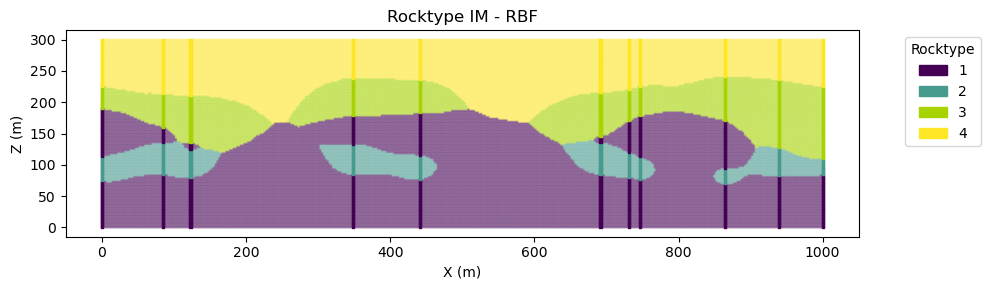

In [30]:
# Crear el gráfico
plt.figure(figsize=(10, 3))
plt.scatter(df3['X'], df3['Z'], c=df3['Rocktype_rbf'], cmap=cmap_discreta, s=1, marker="o", alpha=0.3)  # Rocktype_rbf
plt.scatter(df_sondajes['X'], df_sondajes['Z'], c=df_sondajes['Rocktype'], cmap=cmap_discreta, s=2.5, marker="s")  # Rocktype_rbf

plt.xlabel('X (m)')
plt.ylabel('Z (m)')
plt.title('Rocktype IM - RBF')

# Agregar una leyenda fuera del gráfico
patches = [plt.Rectangle((0, 0), 1, 1, color=cmap_discreta(i)) for i in range(4)]
plt.legend(patches, [1, 2, 3, 4], title='Rocktype', bbox_to_anchor=(1.05, 1), loc='upper left') #bbox_to_anchor para posicionar la leyenda

plt.tight_layout()
plt.savefig("images_3/rocktype_rbf_interpolation.png", dpi=300)
plt.show()

**4. Interpolación con OK:**

In [31]:
from pykrige.ok import OrdinaryKriging
import pykrige.kriging_tools as kt
# Creamos el dataframe vacío para guardar las interpolaciones.

for i in range(1, 5):
    try:
        # Obtener las coordenadas y los valores
        x = df["X"].values
        y = df["Z"].values
        z = df[f"distance_{i}"].values
        # Comprobamos si hay valores nulos
        if np.any(np.isnan(x)) or np.any(np.isnan(y)) or np.any(np.isnan(z)):
            raise ValueError(f"Los datos contienen valores nulos para distance_{i}.")
        # Crear el objeto de Kriging Ordinario
        OK = OrdinaryKriging(
            x,
            y,
            z,
            variogram_model='exponential',  # Puedes cambiar a otros modelos como 'exponential', 'gaussian', etc.
            verbose=False,
            enable_plotting=False
        )

        # Obtener los puntos para la predicción
        x_pred = np.arange(0.0, 1000, 2.5)
        y_pred = np.arange(0.0, 300, 2.5)
        # Realizar la predicción en una cuadrícula
        ZI, ss = OK.execute('grid', x_pred, y_pred)
        # Guardar los resultados en df3
        df3[f"OK_D{i}"] = ZI.flatten()
        df3[f"ROCKTYPE_{i}"] = np.where(df3[f"OK_D{i}"] <= 0, 1, 0)
    except Exception as e:
        print(f"Error al calcular la interpolación Kriging para distance_{i}: {e}")
        df3[f"OK_D{i}"] = np.nan
        df3[f"ROCKTYPE_{i}"] = np.nan
        
df3['Rocktype_ok'] = np.nan  # Inicializamos la columna con 0
for i in range(1, 5):
    df3.loc[df3[f'ROCKTYPE_{i}'] == 1, 'Rocktype_ok'] = i
df3.head()

,X,Z,RBF_D1,ROCKTYPE_1,RBF_D2,ROCKTYPE_2,RBF_D3,ROCKTYPE_3,RBF_D4,ROCKTYPE_4,Rocktype_rbf,OK_D1,OK_D2,OK_D3,OK_D4,Rocktype_ok
0,0.000000,0.0,-75.630252,1,75.630252,0,182.464574,0,226.890756,0,1.0,-75.630252,75.630252,182.464574,226.890756,1.0
1,2.506266,0.0,-75.371002,1,75.027690,0,181.037010,0,226.306817,0,1.0,-74.877424,74.931669,180.456837,225.536776,1.0
2,5.012531,0.0,-75.163061,1,74.504865,0,179.610043,0,225.734254,0,1.0,-74.196658,74.327674,178.456597,224.219509,1.0
3,7.518797,0.0,-75.000731,1,74.054377,0,178.184554,0,225.172091,0,1.0,-73.584556,73.807800,176.475668,222.944536,1.0
4,10.025063,0.0,-74.880826,1,73.672015,0,176.761365,0,224.619932,0,1.0,-73.039196,73.365667,174.520825,221.715202,1.0


In [32]:
# Separar los datos en características (X y Z) y etiquetas (Rocktype_rbf)
X = df3[["X", "Z"]]
y = df3["Rocktype_ok"]

# Crear un modelo de KNN, donde k=1 para obtener el vecino más cercano
knn = KNeighborsClassifier(n_neighbors=1)

# Ajustar el modelo solo con las instancias que no son NaN
knn.fit(X[~y.isna()], y[~y.isna()])

# Predecir los valores para las posiciones donde Rocktype_rbf es NaN
nan_mask = y.isna()
df3.loc[nan_mask, "Rocktype_ok"] = knn.predict(X[nan_mask])

In [33]:
df3["Rocktype_ok"].unique()

array([1., 2., 3., 4.])

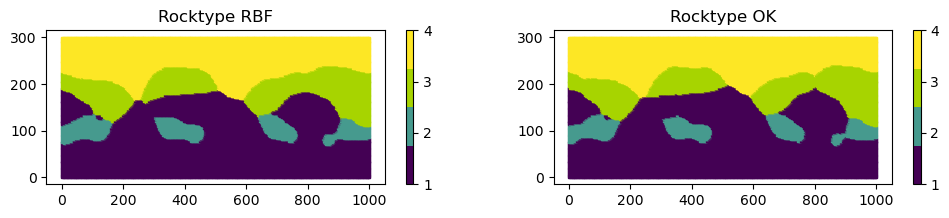

In [34]:
# Visualizamos
plt.figure(figsize=(12, 2))
plt.subplot(1,2,1)
plt.scatter(df3['X'], df3['Z'], c=df3['Rocktype_rbf'], cmap=cmap_discreta, s=1, marker="s")  # Rocktype_rbf
plt.title('Rocktype RBF')
plt.colorbar()
plt.subplot(1,2,2)
plt.scatter(df3['X'], df3['Z'], c=df3['Rocktype_ok'], cmap=cmap_discreta, s=1, marker="s")  # Rocktype_rbf
plt.title('Rocktype OK')
plt.colorbar()
plt.show()

**5. Machine Learning:**

**5.1. MLP:**


Para este enfoque, agregaremos la "densidad" de la roca como un input. 

In [35]:
def asignar_sg(row):
    rocktype = row['Rocktype']
    # Definir límites de densidad para cada tipo de roca
    rock_density_ranges = {
        1: (2.41, 2.7),  # Rango para Rocktype 1
        2: (1.0, 1.8),   # Rango para Rocktype 2
        3: (1.81, 2.2),  # Rango para Rocktype 3
        4: (1.1, 1.5)    # Rango para Rocktype 4
    }
    
    # Asignar densidad según el tipo de roca
    if rocktype in rock_density_ranges:
        lower_bound, upper_bound = rock_density_ranges[rocktype]
        return np.random.uniform(lower_bound, upper_bound)
    else:
        return np.nan  # Manejar valores no esperados en Rocktype

df['sg'] = df.apply(asignar_sg, axis=1)

df.head()

,X,Z,Rocktype,distance_1,distance_2,distance_3,distance_4,sg
0,0.0,0.000000,1,-75.630252,75.630252,182.464574,226.890756,2.419904
1,0.0,2.521008,1,-73.109244,73.109244,180.239214,224.369748,2.546657
2,0.0,5.042017,1,-70.588235,70.588235,178.021737,221.848739,2.646062
3,0.0,7.563025,1,-68.067227,68.067227,175.812441,219.327731,2.579825
4,0.0,10.084034,1,-65.546218,65.546218,173.611639,216.806723,2.616961


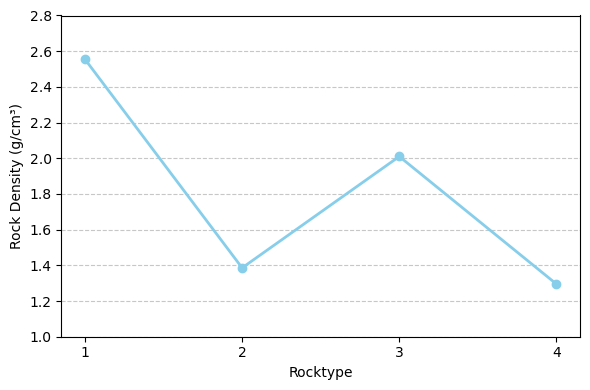

In [36]:
# Calcular la media de 'sg' por 'Rocktype'
mean_sg = df.groupby('Rocktype')['sg'].mean().reset_index()

# Crear el gráfico de líneas
plt.figure(figsize=(6, 4))
plt.plot(mean_sg['Rocktype'], mean_sg['sg'], marker='o', linestyle='-', color='skyblue', linewidth=2)
plt.xlabel('Rocktype')
plt.ylabel('Rock Density (g/cm³)')
#plt.title('Media de sg por Rocktype')

# Configuración del gráfico
plt.xticks(mean_sg['Rocktype'])  # Asegura que todas las etiquetas se muestran
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(1,2.8)
plt.tight_layout()

plt.savefig("images_3/rock_density.png", dpi=300)
plt.show()

In [37]:
#df.to_csv("dataset_drillholes.csv", sep=";", index=None)

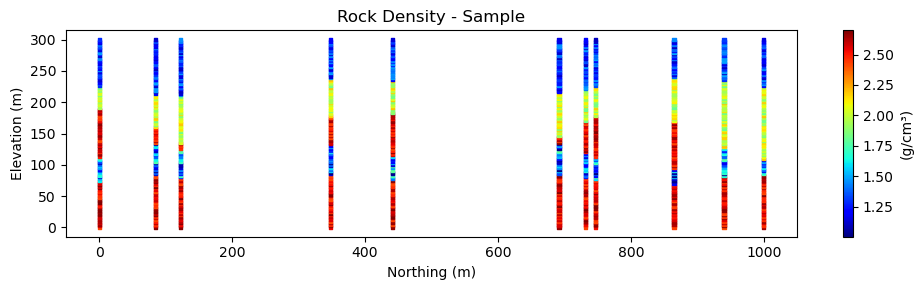

In [38]:
# Crear el gráfico
plt.figure(figsize=(10, 3))
plt.scatter(df['X'], df['Z'], c=df['sg'], cmap="jet", s=5, marker="s")  # Rocktype_rbf
#plt.scatter(df['X'], df['Z'], c=df['Rocktype'], cmap=cmap_discreta, s=20, marker='o', label='Sondajes')

plt.xlabel('Northing (m)')
plt.ylabel('Elevation (m)')
plt.title('Rock Density - Sample')
plt.colorbar(label='(g/cm³)')  # Add a label for the colorbar
plt.tight_layout()
plt.savefig("images_3/rock density sample.png", dpi=300)
plt.show()

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Iteration 1, loss = 1.09260349
Validation score: 0.905660
Iteration 2, loss = 0.53959031
Validation score: 0.971698
Iteration 3, loss = 0.31409665
Validation score: 0.981132
Iteration 4, loss = 0.20143286
Validation score: 0.990566
Iteration 5, loss = 0.14284243
Validation score: 1.000000
Iteration 6, loss = 0.10857128
Validation score: 1.000000
Iteration 7, loss = 0.08588826
Validation score: 1.000000
Iteration 8, loss = 0.07044998
Validation score: 1.000000
Iteration 9, loss = 0.05963041
Validation score: 1.000000
Iteration 10, loss = 0.05137306
Validation score: 1.000000
Iteration 11, loss = 0.04522455
Validation score: 1.000000
Iteration 12, loss = 0.04033788
Validation score: 1.000000
Iteration 13, loss = 0.03627535
Validation score: 1.000000
Iteration 14, loss = 0.03294424
Validation score: 1.000000
Iteration 15, loss = 0.03006652
Validation score: 1.000000
Iteration 16, loss = 0.02760823
Validation score: 1.000000
Val

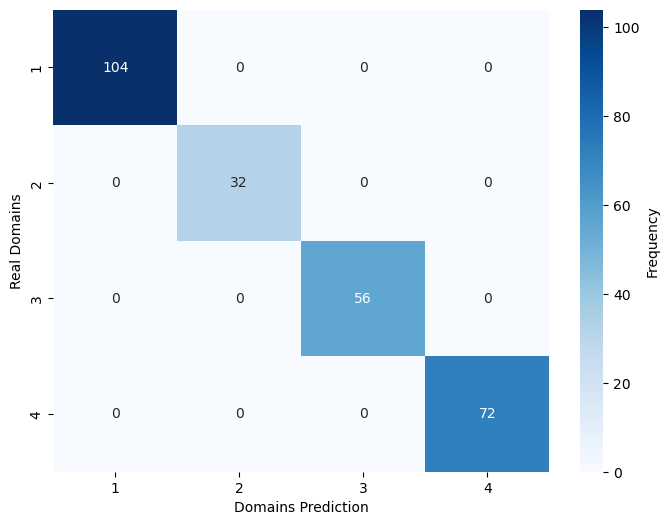

In [39]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Definir las variables de entrada (features) y salida (target)
X = df[['X', 'Z', 'distance_1', 'distance_2','distance_3','distance_4','sg']]
y = df['Rocktype']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) #test_size ajusta la proporción de datos de test

# Escalar las características usando StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
# Definir el espacio de hiperparámetros a explorar
param_grid = {
    'hidden_layer_sizes': [(64, 64), (128,64), (128, 128), (256, 256)], #Ejemplos de combinaciones
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.001], #Parámetro de regularización
    'learning_rate': ['constant', 'adaptive']
}

# Crear el modelo MLP
mlp = MLPClassifier(max_iter=1000, early_stopping=True, random_state=45, verbose=True)

# Crear GridSearchCV
# make_scorer crea un objeto de puntaje que le da a GridSearchCV
grid_search = GridSearchCV(estimator=mlp, param_grid=param_grid, scoring=make_scorer(accuracy_score), cv=5, n_jobs=-1, verbose=2)

#Entrenar con GridSearchCV
grid_search.fit(X_train, y_train)

#Obtener mejores hiperparámetros y el mejor modelo
best_params = grid_search.best_params_
best_mlp = grid_search.best_estimator_

print("Mejores hiperparámetros:", best_params)

# Realizar predicciones en el conjunto de prueba con el mejor modelo
y_pred = best_mlp.predict(X_test)

# Evaluar el modelo
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[1, 2, 3, 4], yticklabels=[1, 2, 3, 4],
            cbar_kws={'label': 'Frequency'})  # Título de la paleta de colores
plt.xlabel('Domains Prediction')
plt.ylabel('Real Domains')
#plt.title('Confusion Matrix - MLPC')
plt.savefig("images_3/mc_mlpc.png", dpi=300)
plt.show()

In [40]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score

y_pred = y_pred
y_true = y_test
    

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
kappa = cohen_kappa_score(y_true, y_pred)
    

# Impresión de resultados
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (weighted): {precision:.4f}")
print(f"Recall (weighted): {recall:.4f}")
print(f"F1-Score (weighted): {f1:.4f}")
print(f"Cohen's Kappa: {kappa:.4f}")

Accuracy: 1.0000
Precision (weighted): 1.0000
Recall (weighted): 1.0000
F1-Score (weighted): 1.0000
Cohen's Kappa: 1.0000


In [41]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
X,1320.0,542.948280,343.692728,0.000000,122.807018,691.729323,864.661654,1000.000000
Z,1320.0,150.000000,87.360358,0.000000,75.000000,150.000000,225.000000,300.000000
Rocktype,1320.0,2.323485,1.228568,1.000000,1.000000,2.000000,3.000000,4.000000
distance_1,1320.0,23.916672,60.200278,-85.714286,-20.168067,12.605042,70.749296,188.418935
distance_2,1320.0,63.843630,55.105401,-25.210084,20.031509,55.462185,105.882353,189.503792
distance_3,1320.0,47.103561,53.425815,-57.983193,5.042017,42.857143,83.193277,184.033613
distance_4,1320.0,76.503088,88.478715,-90.756303,2.521008,77.630994,152.449990,242.016807
sg,1320.0,1.965471,0.557039,1.004116,1.389090,2.020240,2.522268,2.698844


In [42]:
from scipy.interpolate import Rbf

def rbf_interpolation(df, df3, column_to_interpolate):
    """Interpolación usando Radial Basis Function (RBF) para mayor suavidad."""
    
    # Obtener las coordenadas y valores de la columna a interpolar
    x = df["X"].values
    y = df["Z"].values
    z = df[column_to_interpolate].values

    # Crear el interpolador RBF
    rbf = Rbf(x, y, z, function='linear')  # Puedes elegir entre 'linear', 'cubic', 'quintic', etc.

    # Predecir los valores para df3 utilizando las coordenadas de df3
    df3[column_to_interpolate] = rbf(df3["X"].values, df3["Z"].values)
    
    return df3

# Supongamos que df y df3 están definidos, y que df contiene la columna "sg"
df3 = rbf_interpolation(df, df3, 'sg')

df3.head()

,X,Z,RBF_D1,ROCKTYPE_1,RBF_D2,ROCKTYPE_2,RBF_D3,ROCKTYPE_3,RBF_D4,ROCKTYPE_4,Rocktype_rbf,OK_D1,OK_D2,OK_D3,OK_D4,Rocktype_ok,sg
0,0.000000,0.0,-75.630252,1,75.630252,0,182.464574,0,226.890756,0,1.0,-75.630252,75.630252,182.464574,226.890756,1.0,2.419904
1,2.506266,0.0,-75.371002,1,75.027690,0,181.037010,0,226.306817,0,1.0,-74.877424,74.931669,180.456837,225.536776,1.0,2.471363
2,5.012531,0.0,-75.163061,1,74.504865,0,179.610043,0,225.734254,0,1.0,-74.196658,74.327674,178.456597,224.219509,1.0,2.497934
3,7.518797,0.0,-75.000731,1,74.054377,0,178.184554,0,225.172091,0,1.0,-73.584556,73.807800,176.475668,222.944536,1.0,2.514158
4,10.025063,0.0,-74.880826,1,73.672015,0,176.761365,0,224.619932,0,1.0,-73.039196,73.365667,174.520825,221.715202,1.0,2.525994


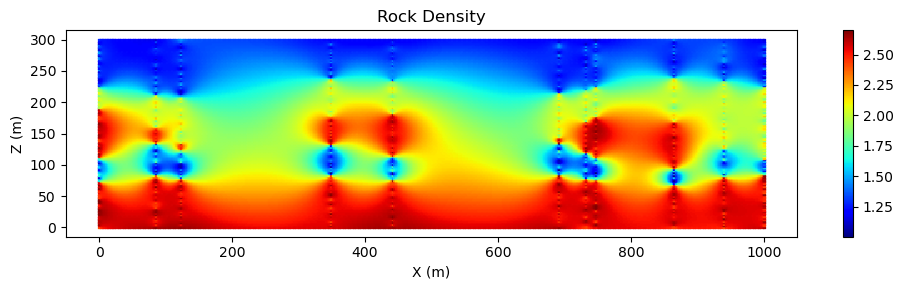

In [43]:
# Crear el gráfico
plt.figure(figsize=(10, 3))
plt.scatter(df3['X'], df3['Z'], c=df3['sg'], cmap="jet", s=1, marker="s")  # Rocktype_rbf
#plt.scatter(df['X'], df['Z'], c=df['Rocktype'], cmap=cmap_discreta, s=20, marker='o', label='Sondajes')

plt.xlabel('X (m)')
plt.ylabel('Z (m)')
plt.title('Rock Density')
plt.colorbar()

plt.tight_layout()
#plt.savefig("images/rocktype_MI_OK.png", dpi=300)
plt.show()

**Importación del modelo SG estimado con OK desde SGEMS:**

In [45]:
# Data for 90 degrees azimuth
data_90 = {
    'h': [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
    'gamma': [0, 0.129983, 0.191474, 0.22412, 0.235146, 0.24496,
              0.272817, 0.300133, 0.305155, 0.288738, 0.265654]
}

# Data for 0 degrees azimuth
data_0 = {
    'h': [0,10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140,
          150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250,
          260, 270, 280, 290, 300],
    'gamma': [0,0.0652055, 0.125815, 0.175954, 0.219139, 0.24837, 
              0.272989, 0.298637, 0.310114, 0.307459, 0.300352,
              0.295573, 0.288557, 0.279383, 0.272204, 0.273289,
              0.285123, 0.308263, 0.349245, 0.400419, 0.476261,
              0.569389, 0.678465, 0.759996, 0.784064, 0.778952, 
              0.774365, 0.777454, 0.781085, 0.781533, 0.792583]
}

# Creating DataFrames
df_90 = pd.DataFrame(data_90)
df_0 = pd.DataFrame(data_0)

# Variogram Model Parameters
nugget = 0.03
contribution = 0.3   # Plateau
range_ = 50          # Range of the variogram

# Function to calculate the exponential variogram
def variogram_exponential(h, nugget, contribution, range_):
    return nugget + contribution * (1 - np.exp(-h / range_))

# Create h values for the variogram plot
h_values = np.linspace(0, 300, 100)  # Up to 300 for better visibility
var_values = variogram_exponential(h_values, nugget, contribution, range_)


# Variogram Model Parameters
nugget1 = 0.03
contribution1 = 0.3   # Plateau
range1_ = 400          # Range of the variogram

# Create h values for the variogram plot
h_values1 = np.linspace(0, 1000, 100)  # Up to 300 for better visibility
var_values1 = variogram_exponential(h_values1, nugget1, contribution1, range1_)


# Plotting
#plt.figure(figsize=(8, 6))
#plt.scatter(df_90['h'], df_90['gamma'], color='black', marker='x', label='Azm=90°; dip=0°')
#plt.scatter(df_0['h'], df_0['gamma'], color='r', marker='x', label='Azm=0°; dip=0°')
#plt.plot(h_values, var_values, color='r', linewidth=2)
#plt.plot(h_values1, var_values1, color='black', linewidth=2)

#plt.xlabel('Lag separation distance', size=18)
#plt.ylabel('Direct variogram', size=18)
#plt.legend()
#plt.grid()
#plt.tight_layout()
#plt.savefig("images_3/gamma_vs_h_azimuths.png", dpi=300)
#plt.show()

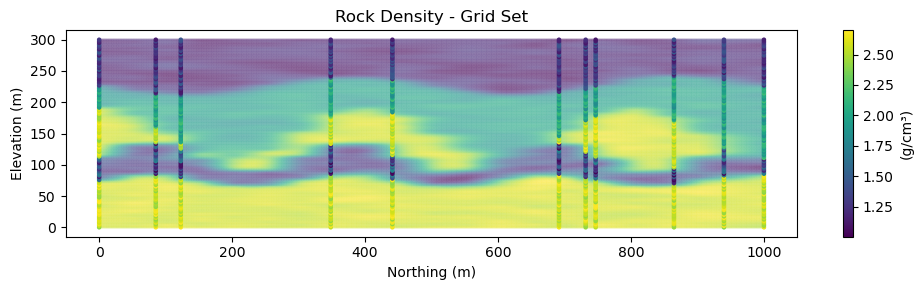

In [46]:
grid_x = np.linspace(0,1000, num=400, endpoint=False) #Coord. de origen x, coord. de termino x, nª de celdas x.
grid_z = np.linspace(0,300, num=120, endpoint=False) #Coord. de origen y, coord. de termino y, nª de celdas y.
gz = np.array(grid_z) #conversión a un array de numpy 
gx = np.array(grid_x) #conversión a un array de numpy 
zg, xg = np.meshgrid(grid_z, grid_x, indexing='ij') #Creación de la grilla (intersecciones en yg; xg)
x_g = xg.ravel() #aplanamiento de xg
z_g = zg.ravel() #aplanamiento de yg

df_read = pd.read_csv("sg_kriging_estimation.csv", sep=";")

d = {'X': x_g, 'Z': z_g} #Columnas con coordenadas X e Y.
df_sg = pd.DataFrame(data=d) #Creación del dataframe 
  
df_sg["sg_ok"] = df_read["ok_sg"] #Traspaso de la columna VA al nuevo DataFrame.
df3["sg"] = df_sg["sg_ok"]

# Crear el gráfico
plt.figure(figsize=(10, 3))

plt.scatter(df3['X'], df3['Z'], c=df3['sg'], cmap="viridis", s=1, marker="o", alpha=0.3)  # Rocktype_rbf
plt.scatter(df['X'], df['Z'], c=df['sg'], cmap="viridis", s=5, marker="o")  # Rocktype_rbf
plt.xlabel('Northing (m)')
plt.ylabel('Elevation (m)')
plt.title('Rock Density - Grid Set')
plt.colorbar(label='(g/cm³)')  # Add a label for the colorbar

plt.tight_layout()
plt.savefig("images_3/rock density grid set.png", dpi=300)
plt.show()

In [48]:
df3 = df3.rename(columns={
    'RBF_D1': 'distance_1',
    'RBF_D2': 'distance_2',
    'RBF_D3': 'distance_3',
    'RBF_D4': 'distance_4'
})
df3.head()

,X,Z,distance_1,ROCKTYPE_1,distance_2,ROCKTYPE_2,distance_3,ROCKTYPE_3,distance_4,ROCKTYPE_4,Rocktype_rbf,OK_D1,OK_D2,OK_D3,OK_D4,Rocktype_ok,sg
0,0.000000,0.0,-75.630252,1,75.630252,0,182.464574,0,226.890756,0,1.0,-75.630252,75.630252,182.464574,226.890756,1.0,2.46940
1,2.506266,0.0,-75.371002,1,75.027690,0,181.037010,0,226.306817,0,1.0,-74.877424,74.931669,180.456837,225.536776,1.0,2.51913
2,5.012531,0.0,-75.163061,1,74.504865,0,179.610043,0,225.734254,0,1.0,-74.196658,74.327674,178.456597,224.219509,1.0,2.52081
3,7.518797,0.0,-75.000731,1,74.054377,0,178.184554,0,225.172091,0,1.0,-73.584556,73.807800,176.475668,222.944536,1.0,2.52216
4,10.025063,0.0,-74.880826,1,73.672015,0,176.761365,0,224.619932,0,1.0,-73.039196,73.365667,174.520825,221.715202,1.0,2.52320


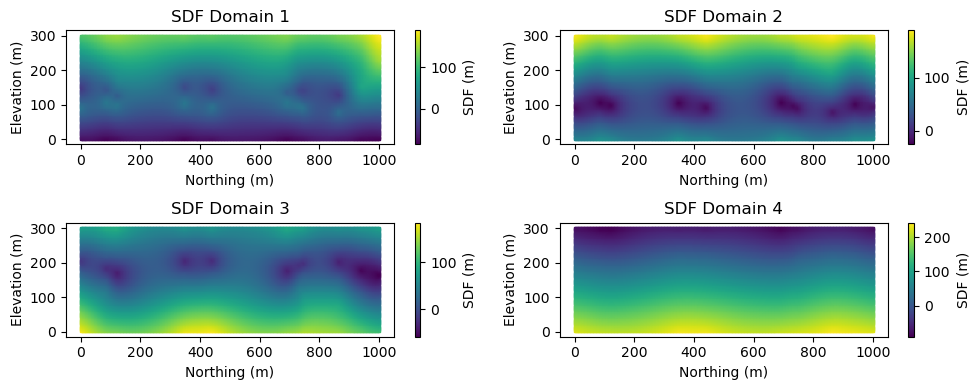

In [49]:
# Crear una figura con 4 subgráficos (2 filas y 2 columnas)
fig, axs = plt.subplots(2, 2, figsize=(10, 4))  # 2 filas y 2 columnas

# Lista de las variables a graficar
distance_vars = ['distance_1', 'distance_2', 'distance_3', 'distance_4']
titles = ['SDF Domain 1', 'SDF Domain 2', 'SDF Domain 3', 'SDF Domain 4']  # Títulos para cada gráfico

# Aplanar el arreglo de ejes para facilitar la iteración
axs = axs.flatten()

for i, distance_var in enumerate(distance_vars):
    scatter = axs[i].scatter(df3['X'], df3['Z'], c=df3[distance_var], cmap="viridis", s=1, marker="s")
    
    axs[i].set_xlabel('Northing (m)')
    axs[i].set_ylabel('Elevation (m)')
    axs[i].set_title(titles[i])
    
    # Agregar la barra de color con una etiqueta
    cbar = plt.colorbar(scatter, ax=axs[i])
    cbar.set_label('SDF (m)')  # Cambia el texto según sea necesario

plt.tight_layout()
plt.savefig("images_3/rocktype_distances.png", dpi=300)
plt.show()

In [50]:
#Escalar las variables en df3
X_df3 = df3[['X', 'Z', 'distance_1', 'distance_2','distance_3','distance_4','sg']]
X_df3_scaled = scaler.transform(X_df3) #Usar el mismo scaler del entrenamiento

# Predecir Rocktype usando el modelo MLP entrenado
df3['Rocktype_MLP'] = best_mlp.predict(X_df3_scaled)

df3.head()

,X,Z,distance_1,ROCKTYPE_1,distance_2,ROCKTYPE_2,distance_3,ROCKTYPE_3,distance_4,ROCKTYPE_4,Rocktype_rbf,OK_D1,OK_D2,OK_D3,OK_D4,Rocktype_ok,sg,Rocktype_MLP
0,0.000000,0.0,-75.630252,1,75.630252,0,182.464574,0,226.890756,0,1.0,-75.630252,75.630252,182.464574,226.890756,1.0,2.46940,1
1,2.506266,0.0,-75.371002,1,75.027690,0,181.037010,0,226.306817,0,1.0,-74.877424,74.931669,180.456837,225.536776,1.0,2.51913,1
2,5.012531,0.0,-75.163061,1,74.504865,0,179.610043,0,225.734254,0,1.0,-74.196658,74.327674,178.456597,224.219509,1.0,2.52081,1
3,7.518797,0.0,-75.000731,1,74.054377,0,178.184554,0,225.172091,0,1.0,-73.584556,73.807800,176.475668,222.944536,1.0,2.52216,1
4,10.025063,0.0,-74.880826,1,73.672015,0,176.761365,0,224.619932,0,1.0,-73.039196,73.365667,174.520825,221.715202,1.0,2.52320,1


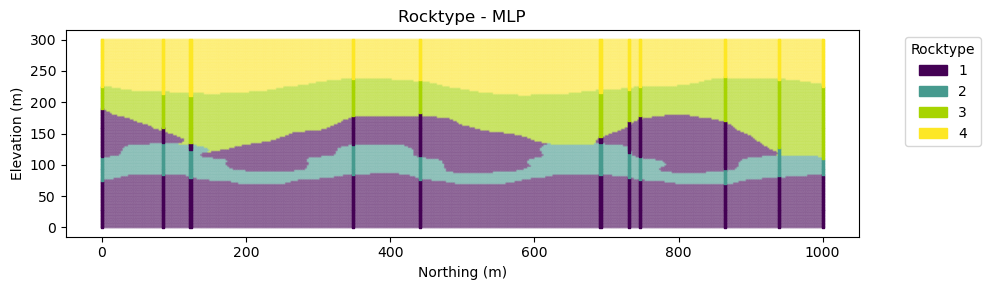

In [51]:
# Crear el gráfico
plt.figure(figsize=(10, 3))

plt.scatter(df3['X'], df3['Z'], c=df3['Rocktype_MLP'], cmap=cmap_discreta, s=1, marker="o", alpha=0.3)  # Rocktype_rbf
plt.scatter(df_sondajes['X'], df_sondajes['Z'], c=df_sondajes['Rocktype'], cmap=cmap_discreta, s=2.5, marker="s")  # Rocktype_rbf


plt.xlabel('Northing (m)')
plt.ylabel('Elevation (m)')
plt.title('Rocktype - MLP')

# Agregar una leyenda fuera del gráfico
patches = [plt.Rectangle((0, 0), 1, 1, color=cmap_discreta(i)) for i in range(4)]
plt.legend(patches, [1, 2, 3, 4], title='Rocktype', bbox_to_anchor=(1.05, 1), loc='upper left') #bbox_to_anchor para posicionar la leyenda

plt.tight_layout()
plt.savefig("images_3/rocktype_MLP.png", dpi=300)
plt.show()

In [52]:
df3['Rocktype_REAL'] = df_completo["Rocktype"]
df3.head()

,X,Z,distance_1,ROCKTYPE_1,distance_2,ROCKTYPE_2,distance_3,ROCKTYPE_3,distance_4,ROCKTYPE_4,Rocktype_rbf,OK_D1,OK_D2,OK_D3,OK_D4,Rocktype_ok,sg,Rocktype_MLP,Rocktype_REAL
0,0.000000,0.0,-75.630252,1,75.630252,0,182.464574,0,226.890756,0,1.0,-75.630252,75.630252,182.464574,226.890756,1.0,2.46940,1,1
1,2.506266,0.0,-75.371002,1,75.027690,0,181.037010,0,226.306817,0,1.0,-74.877424,74.931669,180.456837,225.536776,1.0,2.51913,1,1
2,5.012531,0.0,-75.163061,1,74.504865,0,179.610043,0,225.734254,0,1.0,-74.196658,74.327674,178.456597,224.219509,1.0,2.52081,1,1
3,7.518797,0.0,-75.000731,1,74.054377,0,178.184554,0,225.172091,0,1.0,-73.584556,73.807800,176.475668,222.944536,1.0,2.52216,1,1
4,10.025063,0.0,-74.880826,1,73.672015,0,176.761365,0,224.619932,0,1.0,-73.039196,73.365667,174.520825,221.715202,1.0,2.52320,1,1


In [53]:
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score

# Supongamos que df3 es tu DataFrame con las variables
# df3 = pd.DataFrame(...)  # Cargar tu DataFrame aquí

# Lista de columnas estimadas y la columna real
estimaciones = ['Rocktype_rbf', 'Rocktype_ok', 'Rocktype_MLP']
real = 'Rocktype_REAL'

# Inicializar un diccionario para almacenar los resultados
resultados = {
    'Modelo': [],
    'Precisión': [],
    'Exhaustividad': [],
    'Score F1': [],
    'Kappa': [],
    'Exactitud': []
}

# Calcular métricas para cada estimación
for modelo in estimaciones:
    y_pred = df3[modelo]
    y_true = df3[real]
    
    # Calcular métricas
    
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    kappa = cohen_kappa_score(y_true, y_pred)
    
    # Almacenar resultados en el diccionario
    resultados['Modelo'].append(modelo)
    
    resultados['Precisión'].append(precision)
    resultados['Exhaustividad'].append(recall)
    resultados['Score F1'].append(f1)
    resultados['Kappa'].append(kappa)
    resultados['Exactitud'].append(accuracy)


# Convertir el diccionario a un DataFrame para una mejor visualización
resultados_df = pd.DataFrame(resultados)

# Mostrar los resultados
print(resultados_df)

         Modelo  Precisión  Exhaustividad  Score F1     Kappa  Exactitud
0  Rocktype_rbf   0.878166       0.866833  0.860412  0.809556   0.866833
1   Rocktype_ok   0.874993       0.860458  0.853319  0.799674   0.860458
2  Rocktype_MLP   0.939821       0.939604  0.939368  0.915131   0.939604


In [54]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score

# Supongamos que df3 es tu DataFrame ya cargado
# df3 = pd.DataFrame(...)  # Cargar tu DataFrame aquí

# Lista de columnas estimadas y la columna real
estimaciones = ['Rocktype_rbf', 'Rocktype_ok', 'Rocktype_MLP']
real = 'Rocktype_REAL'

# Diccionario para renombrar los modelos
nombres_modelos = {
    'Rocktype_rbf': 'IM -RBF',
    'Rocktype_ok': 'IM -OK',
    'Rocktype_MLP': 'MIM'
}

# Inicializar un diccionario para almacenar los resultados
resultados = {
    'Modelo': [],
    'Matriz de Confusión': [],
    'Precisión': [],
    'Exhaustividad': [],
    'Score F1': [],
    'Kappa': [],
    'Exactitud': []
}

# Calcular métricas para cada estimación
for modelo in estimaciones:
    y_pred = df3[modelo]
    y_true = df3[real]
    
    # Calcular métricas
    conf_matrix = confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    kappa = cohen_kappa_score(y_true, y_pred)
    
    # Almacenar resultados en el diccionario
    resultados['Modelo'].append(modelo)
    resultados['Matriz de Confusión'].append(conf_matrix)
    resultados['Precisión'].append(precision)
    resultados['Exhaustividad'].append(recall)
    resultados['Score F1'].append(f1)
    resultados['Kappa'].append(kappa)
    resultados['Exactitud'].append(accuracy)

# Convertir el diccionario a un DataFrame para una mejor visualización
resultados_df = pd.DataFrame(resultados)

# Visualización de la matriz de confusión para cada modelo
for modelo in estimaciones:
    # Obtener la matriz de confusión
    cm = confusion_matrix(df3[real], df3[modelo])
    
    plt.figure(figsize=(8, 6))

   
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=np.unique(df3[real]), yticklabels=np.unique(df3[real]),
                cbar_kws={'label': 'Frequency'})  # Etiqueta de la barra de color
    
    # Usar el nombre renombrado para el modelo
    titulo_modelo = nombres_modelos[modelo]
    plt.title(f'Confusion matrix for {titulo_modelo}')
    plt.xlabel('Domains Prediction')
    plt.ylabel('Real Domains')
    
    # Guardar la figura en un archivo
    plt.savefig(f"images_2/matriz_confusion_{titulo_modelo.replace(' ', '_')}.png")  # Guarda la figura como PNG
    plt.close()  # Cierra la figura para liberar memoria

# Mostramos el DataFrame de resultados (opcional)
print(resultados_df)

         Modelo                                Matriz de Confusión  Precisión  \
0  Rocktype_rbf  [[17801, 264, 328, 0], [2233, 3371, 3, 0], [18...   0.878166   
1   Rocktype_ok  [[17973, 234, 186, 0], [2389, 3218, 0, 0], [23...   0.874993   
2  Rocktype_MLP  [[17655, 228, 510, 0], [564, 5004, 39, 0], [98...   0.939821   

   Exhaustividad  Score F1     Kappa  Exactitud  
0       0.866833  0.860412  0.809556   0.866833  
1       0.860458  0.853319  0.799674   0.860458  
2       0.939604  0.939368  0.915131   0.939604  


**POST-PROCESO:**

In [55]:

df_filtered = df3[['X', 'Z', 'Rocktype_MLP']].copy()


df_filtered.rename(columns={'Rocktype_MLP': 'Rocktype'}, inplace=True)

# Luego, toma una muestra aleatoria del 80% de los datos
#df_post = df_filtered.sample(frac=0.7, random_state=42)  # random_state para reproducibilidad

df_post = df_filtered.copy()
df_post.describe().T

,count,mean,std,min,25%,50%,75%,max
X,48000.0,500.000000,289.400741,0.0,250.0,500.0,750.0,1000.0
Z,48000.0,150.000000,87.328170,0.0,75.0,150.0,225.0,300.0
Rocktype,48000.0,2.339437,1.235888,1.0,1.0,2.0,4.0,4.0


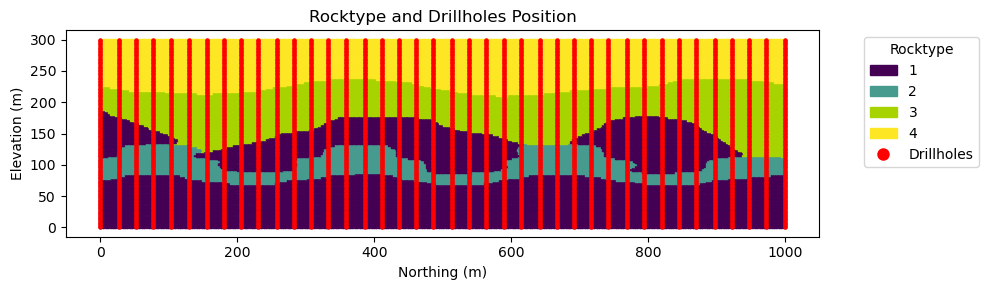

In [56]:
cmap_discreta = ListedColormap(['#440154', '#469A8E', '#A7D400', '#FDE725'])

# Parámetros
num_points_x = 400  # Asumiendo que esto ya está definido
num_points_z = 120  # Asumiendo que esto ya está definido
num_sondajes = 40  # Número total de sondajes

# Crear el subconjunto de datos simulando sondajes verticales
indices_sondajes = [0, num_points_x - 1]  # Asegurar que hay un sondaje en X = 0 y X = 1000

# Calcular el número de sondajes restantes
remaining_sondajes = num_sondajes - len(indices_sondajes)

# Generar índices de los sondajes restantes de forma regular
if remaining_sondajes > 0:
    # Calcular la separación entre los indices de sondajes
    step = (num_points_x - 2) / (remaining_sondajes + 1)  # +1 for the extra space (0 and 1000)

    # Crear los índices equidistantes a partir de 1 hasta num_points_x - 1
    additional_indices = [int(i * step) + 1 for i in range(1, remaining_sondajes + 1)]
    indices_sondajes.extend(additional_indices)

# Crear una lista para almacenar los DataFrames de cada sondaje
sondajes_list = []

# Extraemos todos los valores de Z correspondientes a cada X seleccionado
for indice in indices_sondajes:
    # Creamos un DataFrame con todas las filas de Z para el X actual
    df_sondaje_vertical = df_post.iloc[indice::num_points_x]
    # Agregamos este DataFrame a la lista
    sondajes_list.append(df_sondaje_vertical)

# Concatenamos todos los DataFrames de los sondajes en uno solo
df_sondajes2 = pd.concat(sondajes_list, ignore_index=True)

# Crear el gráfico
plt.figure(figsize=(10, 3))
plt.scatter(df_post['X'], df_post['Z'], c=df_post['Rocktype'], cmap=cmap_discreta, s=1, marker="s")  # Rocktype_rbf
plt.scatter(df_sondajes2['X'], df_sondajes2['Z'], c='red', s=5, marker='o', label='Drillholes')

plt.xlabel('Northing (m)')
plt.ylabel('Elevation (m)')
plt.title('Rocktype and Drillholes Position')

# Agregar una leyenda fuera del gráfico
patches = [plt.Rectangle((0, 0), 1, 1, color=cmap_discreta(i)) for i in range(4)]
plt.legend(patches + [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Drillholes')],
           [1, 2, 3, 4, 'Drillholes'], title='Rocktype', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.savefig("images_3/rocktype_real22.png", dpi=300)
plt.show()

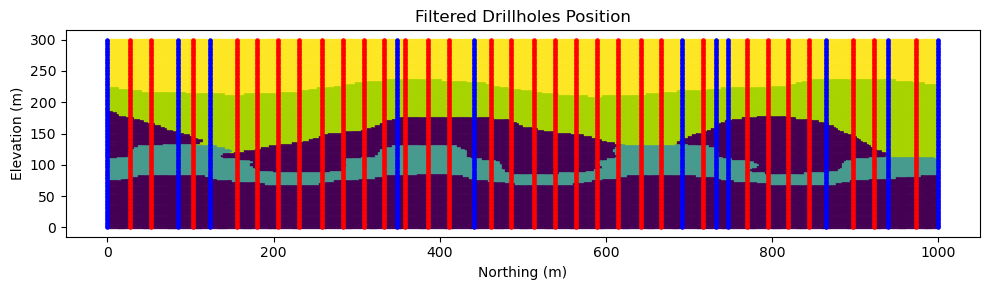

In [57]:
distancia_minima = 10  # Ajusta este valor según sea necesario

# Función para calcular la distancia entre dos sondajes
def calcular_distancia(punto1, punto2):
    return np.sqrt((punto1[0] - punto2[0]) ** 2 + (punto1[1] - punto2[1]) ** 2)

# Filtrar los sondajes en df_sondajes2 que están cerca de los sondajes en df_sondajes
sondajes_filtrados = []

for _, sondaje2 in df_sondajes2.iterrows():
    esta_cerca = False
    for _, sondaje in df_sondajes.iterrows():
        distancia = calcular_distancia((sondaje2['X'], sondaje2['Z']), (sondaje['X'], sondaje['Z']))
        if distancia < distancia_minima:
            esta_cerca = True
            break
    if not esta_cerca:
        sondajes_filtrados.append(sondaje2)

# Crear un DataFrame a partir de los sondajes filtrados
df_sondajes2_filtrados = pd.DataFrame(sondajes_filtrados)

# Unir df_sondajes con df_sondajes2_filtrados en df_sondajes3
df_sondajes2 = pd.concat([df_sondajes, df_sondajes2_filtrados], ignore_index=True)

# Visualización de los resultados
plt.figure(figsize=(10, 3))
cmap_discreta = ListedColormap(['#440154', '#469A8E', '#A7D400', '#FDE725'])
plt.scatter(df_post['X'], df_post['Z'], c=df_post['Rocktype'], cmap=cmap_discreta, s=1, marker="s")  # Rocktype_rbf
plt.scatter(df_sondajes['X'], df_sondajes['Z'], c='blue', s=5, label='Original Drillholes')
plt.scatter(df_sondajes2_filtrados['X'], df_sondajes2_filtrados['Z'], c='red', s=5, marker='o', label='Filtered Drillholes')

plt.xlabel('Northing (m)')
plt.ylabel('Elevation (m)')
plt.title('Filtered Drillholes Position')

plt.tight_layout()

plt.show()

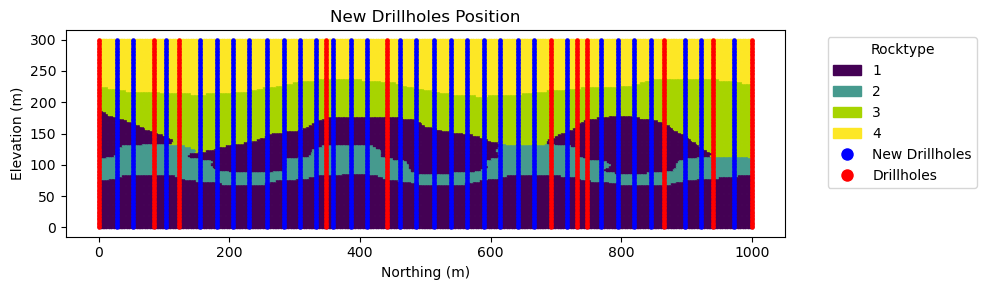

In [58]:
# Visualización de los resultados
plt.figure(figsize=(10, 3))
cmap_discreta = ListedColormap(['#440154', '#469A8E', '#A7D400', '#FDE725'])
plt.scatter(df_post['X'], df_post['Z'], c=df_post['Rocktype'], cmap=cmap_discreta, s=1, marker="s")  # Rocktype_rbf
plt.scatter(df_sondajes['X'], df_sondajes['Z'], c='red', s=5, label='Original Drillholes')
plt.scatter(df_sondajes2_filtrados['X'], df_sondajes2_filtrados['Z'], c='blue', s=5, marker='o', label='Filtered Drillholes')

plt.xlabel('Northing (m)')
plt.ylabel('Elevation (m)')
plt.title('New Drillholes Position')

# Crear los elementos de la leyenda
patches = [plt.Rectangle((0, 0), 1, 1, color=cmap_discreta(i)) for i in range(4)]
drillholes_legend = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='b', markersize=10, label='Drillholes')
existing_drillholes_legend = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='New Drillholes')

# Combinar todos los elementos en una sola leyenda
legend_elements = patches + [drillholes_legend, existing_drillholes_legend]
legend_labels = [1, 2, 3, 4, 'New Drillholes', 'Drillholes']

# Agregar la leyenda unificada al gráfico
plt.legend(legend_elements, legend_labels, title='Rocktype', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.savefig("images_3/new_drillholes.png", dpi=300)
plt.show()

In [59]:
df_sondajes2.describe().T

,count,mean,std,min,25%,50%,75%,max
X,5040.0,501.849863,290.905753,0.0,258.145363,500.0,746.867168,1000.0
Z,5040.0,150.000000,87.335925,0.0,75.000000,150.0,225.000000,300.0
Rocktype,5040.0,2.328770,1.238900,1.0,1.000000,2.0,4.000000,4.0


In [60]:
# Número de dominios (tipos de roca)
K = df_sondajes2['Rocktype'].nunique()
# Convertimos las columnas X, Z y Rocktype a arrays NumPy
X = df_sondajes2['X'].values
Z = df_sondajes2['Z'].values
Rocktype = df_sondajes2['Rocktype'].values
# Calculamos la matriz de distancias entre todos los puntos
dist_matrix = np.sqrt((X[:, np.newaxis] - X)**2 + (Z[:, np.newaxis] - Z)**2)
# Creamos columnas para las distancias de cada tipo de roca
for k in range(1, K + 1):
    column_name = f'distance_{k}'
    distances_k = np.zeros_like(X)
    domain_indices = np.where(Rocktype == k)[0]
    other_indices = np.where(Rocktype != k)[0]
    if len(domain_indices) > 0 and len(other_indices) > 0:
        min_dist_to_other = np.min(dist_matrix[domain_indices[:, None], other_indices], axis=1)
        distances_k[domain_indices] = -min_dist_to_other
        min_dist_to_domain = np.min(dist_matrix[other_indices[:, None], domain_indices], axis=1)
        distances_k[other_indices] = min_dist_to_domain
    df_sondajes2[column_name] = distances_k
df_sondajes2.drop_duplicates(subset=['X', 'Z'], inplace=True)

In [61]:
df2 = df_completo.copy()
df2 = df2.drop_duplicates(subset=['X', 'Z'])
df2.describe().T

,count,mean,std,min,25%,50%,75%,max
X,48000.0,500.000000,289.400741,0.0,250.0,500.0,750.0,1000.0
Z,48000.0,150.000000,87.328170,0.0,75.0,150.0,225.0,300.0
Rocktype,48000.0,2.368729,1.225972,1.0,1.0,2.5,4.0,4.0


In [62]:
# Creamos el dataframe vacio para guardar las interpolaciones.
df4 = pd.DataFrame({'X': df2['X'], 'Z': df2['Z']})
for i in range(1, 5):
    try:
        x = df_sondajes2["X"]
        y = df_sondajes2["Z"]
        z = df_sondajes2[f"distance_{i}"]
        rbf = Rbf(x, y, z, function="linear")
        ZI = rbf(df2["X"].to_numpy(), df2["Z"].to_numpy())
        df4[f"RBF_D{i}"] = ZI.flatten()
        df4[f"ROCKTYPE_{i}"] = np.where(df4[f"RBF_D{i}"] <= 0, 1, 0)

    except np.linalg.LinAlgError:
        print(f"Error al calcular la interpolación RBF para distance_{i}.  La matriz es singular.  Revisa los datos.")
        df4[f"RBF_D{i}"] = np.nan
        df4[f"ROCKTYPE_{i}"] = np.nan
        
df4['Rocktype_rbf'] = np.nan  # Inicializamos la columna con 0
for i in range(1, 5):
    df4.loc[df4[f'ROCKTYPE_{i}'] == 1, 'Rocktype_rbf'] = i
df4.head()

,X,Z,RBF_D1,ROCKTYPE_1,RBF_D2,ROCKTYPE_2,RBF_D3,ROCKTYPE_3,RBF_D4,ROCKTYPE_4,Rocktype_rbf
0,0.000000,0.0,-75.630252,1,75.630252,0,176.917630,0,223.555158,0,1.0
1,2.506266,0.0,-75.806977,1,75.687373,0,175.855322,0,223.206547,0,1.0
2,5.012531,0.0,-76.053876,1,75.852385,0,174.821077,0,222.875895,0,1.0
3,7.518797,0.0,-76.358367,1,76.106436,0,173.808282,0,222.560266,0,1.0
4,10.025063,0.0,-76.713250,1,76.437862,0,172.812934,0,222.259162,0,1.0


In [63]:
# Separar los datos en características (X y Z) y etiquetas (Rocktype_rbf)
X = df4[["X", "Z"]]
y = df4["Rocktype_rbf"]

# Crear un modelo de KNN, donde k=1 para obtener el vecino más cercano
knn = KNeighborsClassifier(n_neighbors=1)

# Ajustar el modelo solo con las instancias que no son NaN
knn.fit(X[~y.isna()], y[~y.isna()])

# Predecir los valores para las posiciones donde Rocktype_rbf es NaN
nan_mask = y.isna()
df4.loc[nan_mask, "Rocktype_rbf"] = knn.predict(X[nan_mask])

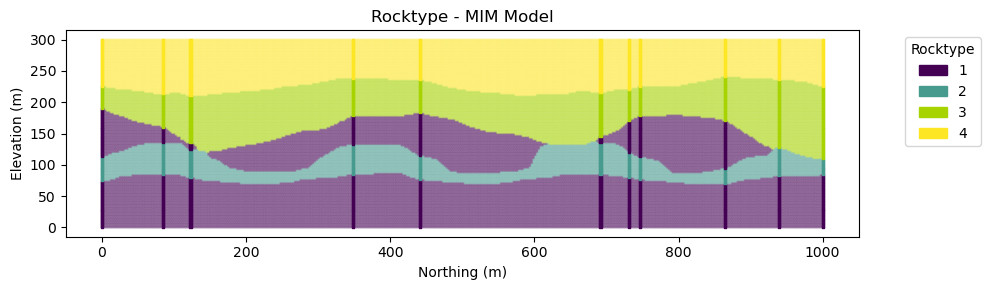

In [64]:
# Crear el gráfico
plt.figure(figsize=(10, 3))
plt.scatter(df4['X'], df4['Z'], c=df4['Rocktype_rbf'], cmap=cmap_discreta, s=1, marker="o", alpha=0.3)  # Rocktype_rbf
plt.scatter(df_sondajes['X'], df_sondajes['Z'], c=df_sondajes['Rocktype'], cmap=cmap_discreta, s=2.5, marker="s")  # Rocktype_rbf


plt.xlabel('Northing (m)')
plt.ylabel('Elevation (m)')
plt.title('Rocktype - MIM Model')

# Agregar una leyenda fuera del gráfico
patches = [plt.Rectangle((0, 0), 1, 1, color=cmap_discreta(i)) for i in range(4)]
plt.legend(patches, [1, 2, 3, 4], title='Rocktype', bbox_to_anchor=(1.05, 1), loc='upper left') #bbox_to_anchor para posicionar la leyenda

plt.tight_layout()
plt.savefig("images_3/rocktype_MLP_postrbf.png", dpi=300)
plt.show()

In [66]:
df4["Rocktype_REAL"] = df3["Rocktype_REAL"]

In [67]:
df4.describe().T

,count,mean,std,min,25%,50%,75%,max
X,48000.0,500.000000,289.400741,0.000000,250.000000,500.000000,750.000000,1000.000000
Z,48000.0,150.000000,87.328170,0.000000,75.000000,150.000000,225.000000,300.000000
RBF_D1,48000.0,23.557051,58.752431,-88.235294,-19.393418,12.064469,69.057219,184.953325
ROCKTYPE_1,48000.0,0.401542,0.490215,0.000000,0.000000,0.000000,1.000000,1.000000
RBF_D2,48000.0,65.747943,54.596972,-25.671449,21.734376,57.784449,106.769095,199.866791
ROCKTYPE_2,48000.0,0.113937,0.317739,0.000000,0.000000,0.000000,0.000000,1.000000
RBF_D3,48000.0,44.917937,51.573201,-57.983193,3.247913,41.007627,80.154458,178.991597
ROCKTYPE_3,48000.0,0.232271,0.422285,0.000000,0.000000,0.000000,0.000000,1.000000
RBF_D4,48000.0,74.584691,87.888150,-90.756303,-1.421282,75.574750,150.162694,239.495798
ROCKTYPE_4,48000.0,0.253271,0.434889,0.000000,0.000000,0.000000,1.000000,1.000000


In [68]:
y_pred = df4["Rocktype_rbf"]
y_true = df4["Rocktype_REAL"]
    

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
kappa = cohen_kappa_score(y_true, y_pred)
    

# Impresión de resultados
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (weighted): {precision:.4f}")
print(f"Recall (weighted): {recall:.4f}")
print(f"F1-Score (weighted): {f1:.4f}")
print(f"Cohen's Kappa: {kappa:.4f}")

Accuracy: 0.9472
Precision (weighted): 0.9476
Recall (weighted): 0.9472
F1-Score (weighted): 0.9469
Cohen's Kappa: 0.9258
